<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/4Neural_Network_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time

df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')
#df = df[df['n/m'] !=2]
print(df.shape[0])

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']

8750


In [2]:
X_modified = X.drop([ 'median','max', 'k', 'min', 'range',  'indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n','m'], axis = 1)
print(X_modified.head())
#X_modified = X.drop(['max', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', '(m/n)^2', '(m/n)^3', 'class', 'av.length'], axis = 1)

     n   n/m   av.length    std.dev
0  180   4.5   76.361115  14.465434
1  140  10.0   57.099998  23.167305
2  100  10.0  262.730011  82.378159
3   90   6.0  370.066681  83.580521
4  180   9.0   99.150002  19.391722


In [3]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

#smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:5000})
#X_modified, y = oversample.fit_resample(X_modified, y)
#print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
tmp = tmp.sample(frac = 1).reset_index()
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

1655304


In [4]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow
from tensorflow import keras 


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,1))
    return 99999*1/(1+K.exp(-x))

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))

    #classifier.add(Dense(32, activation = 'relu'))
    #classifier.add(Dense(32, activation = 'relu'))
    #classifier.add(Dense(16, activation = 'relu'))

    #model.add(Dense(32, activation='relu'))

    #model.add(Dense(64, activation='relu'))

    #model.add(Dense(8, activation='relu'))
    
    model.add(Dense(1, activation = custom_activation))
    #model.add(Activation(custom_activation, name='SpecialActivation'))
    #model.compile(loss='mean_squared_error', optimizer=tensorflow.keras.optimizers.Adam(clipnorm=1))
    #model.compile(loss='mean_squared_error', optimizer='RMSProp')
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [5]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=15, batch_size=128, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/15
10734/10734 [==============================] - 26s 2ms/step - loss: 14665993.0000
Epoch 2/15
10734/10734 [==============================] - 15s 1ms/step - loss: 3017447.0000
Epoch 3/15
10734/10734 [==============================] - 16s 1ms/step - loss: 2067611.3750
Epoch 4/15
10734/10734 [==============================] - 16s 1ms/step - loss: 1837251.1250
Epoch 5/15
10734/10734 [==============================] - 16s 1ms/step - loss: 1705193.6250
Epoch 6/15
10734/10734 [==============================] - 16s 2ms/step - loss: 1635966.0000
Epoch 7/15
10734/10734 [==============================] - 17s 2ms/step - loss: 1552799.2500
Epoch 8/15
10734/10734 [==============================] - 17s 2ms/step - loss: 1572796.0000
Epoch 9/15
10734/10734 [==============================] - 16s 1ms/step - loss: 1579648.5000
Epoch 10/15
10734/10734 [==============================] - 16s 1ms/step - loss: 1516242.1250
Epoch 11/15
10734/10734 [==============================] - 16s 1ms/step - loss

2/2 [==============================] - 0s 7ms/step
[  25.57487     14.233322   566.6817    1195.201      269.33313
  466.7138    1774.7307    1825.9463    2332.3557     584.8998
 1499.719     2165.9707    1020.7358    2415.3965      19.115015
 2113.8218    1936.254     3207.882     3458.5393     845.2837
  103.084     1595.7039     950.8939    3524.1235    1096.2383
   21.763145    43.961617  1295.8755    1032.0187    1248.7429
  191.99957   1660.6432      24.855894   941.4487    1405.3289
  415.22885    256.4592     280.57175    377.21277     13.651135
  683.5013      87.46372     46.26263    227.16615   1421.4884
  298.0442     295.76202     39.65977   1276.5177     871.83826
 2645.4258     815.16284     23.271357   844.843      814.3867
  557.32355    649.7534     193.90826    587.5966     446.35294
 2581.395      767.25037    529.3821    1592.164     3606.603
  923.2314    1923.9244     242.80077   3305.023      302.38934
 1535.1674    1773.9379     183.8507       7.7019935  866.83

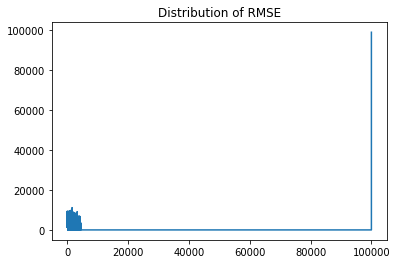

In [6]:
X_test_tmp = pd.DataFrame(X_test, columns = X_test_copy.columns)
tmp = X_test_tmp
tmp['y'] = y

uniq = tmp['y'].unique()

all_dict = {elem: pd.DataFrame() for elem in uniq}

results = np.zeros(100000)
for i in range(100000):
  results[i]=0

from sklearn.metrics import mean_squared_error
from math import sqrt


for key in all_dict:
  all_dict[key] = tmp[:][tmp['y'] == key]
  X_test_key = all_dict[key].drop(['y'], axis = 1)
  y_test_key = all_dict[key]['y']
  predicted = estimator.predict(X_test_key)
  if(key == 99999):
    print(predicted)
  predd = np.array(predicted)
  yy = np.array(y_test_key)
  results[key] = sqrt(mean_squared_error(yy, predd))

plt.title('Distribution of RMSE')
plt.plot(results)

246


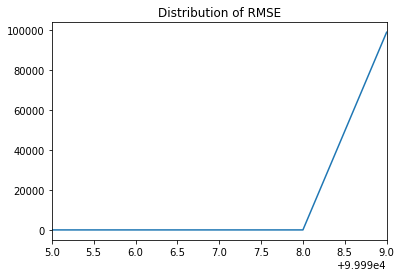

In [7]:
print(all_dict[99999].shape[0])
plt.title('Distribution of RMSE')
plt.xlim([99995, 99999])
plt.plot(results)

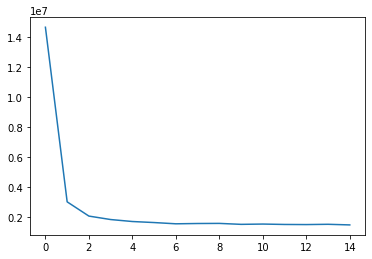

In [8]:
plt.plot(history.history['loss'])

In [9]:
#from sklearn.metrics import r2_score
#prediction = estimator.predict(X_val)
#print("r_square score: ", r2_score(y_val,prediction))
##y_test = sc2.inverse_transform(y_test.reshape(-1,1))
#yy = np.array(y_val)
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
#predd = np.array(prediction)
#for i in range(len(yy)):
#  if(yy[i]-predd[i] > 99000):
#    print("real value of y_test: " + str(yy[i]) + " -> the predict: " + str(predd[i]))

In [10]:
#from sklearn.metrics import mean_squared_error
#from math import sqrt

#print("RMSE:")
#sqrt(mean_squared_error(yy, predd)) 

In [11]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)


av_bad = []
n_bad = []
std_dev_bad = []
#max_bad = []
nm_bad = []
#k_bad = []
#min_bad = []

av_good = []
n_good = []
std_dev_good = []
nm_good = []
#max_good = []
#k_good = []
#min_good = []

for i in range(len(yy)):
  if(yy[i]-predd[i] > 99000):
    av_bad.append(X_test_copy.iloc[i]['av.length'])
    n_bad.append(X_test_copy.iloc[i]['n'])
    std_dev_bad.append(X_test_copy.iloc[i]['std.dev'])
    nm_bad.append(X_test_copy.iloc[i]['n/m'])
 #   max_bad.append(X_test_copy.iloc[i]['max'])
  #  k_bad.append(X_test_copy.iloc[i]['k'])
    #min_bad.append(X_test_copy.iloc[i]['min'])

    print("real value of y_test: " + str(yy[i]) + " -> the predict: " + str(predd[i]))
  if(abs(yy[i]-predd[i])<100 and yy[i]>99500):
    av_good.append(X_test_copy.iloc[i]['av.length'])
    n_good.append(X_test_copy.iloc[i]['n'])
    std_dev_good.append(X_test_copy.iloc[i]['std.dev'])
    nm_good.append(X_test_copy.iloc[i]['n/m'])
   # max_good.append(X_test_copy.iloc[i]['max'])
    #k_good.append(X_test_copy.iloc[i]['k'])
    #min_good.append(X_test_copy.iloc[i]['min'])



2199/2199 [==============================] - 3s 1ms/step
r_square score:  0.8729380230731486
real value of y_test: 99999 -> the predict: 12.571954
real value of y_test: 99999 -> the predict: 31.221418
real value of y_test: 99999 -> the predict: 6.646991


In [12]:
print(np.max(predd))

99999.0


In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd)) 

RMSE:


1125.127281174679

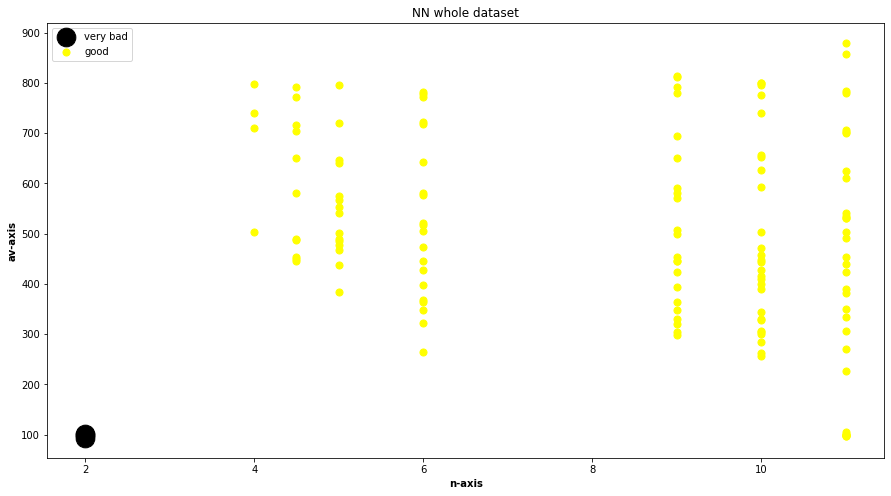

In [14]:
fig = plt.figure(figsize = (15, 8))
ax = plt.axes()

ax.scatter(nm_bad, av_bad, s = 350, color = 'black')
ax.scatter(nm_good, av_good, s= 50, color = 'yellow')

ax.set_xlabel('n-axis', fontweight ='bold')
ax.set_ylabel('av-axis', fontweight ='bold')
plt.title("NN whole dataset")
 
ax.legend(['very bad', 'good'])
# show plot
plt.show()

NameError: ignored

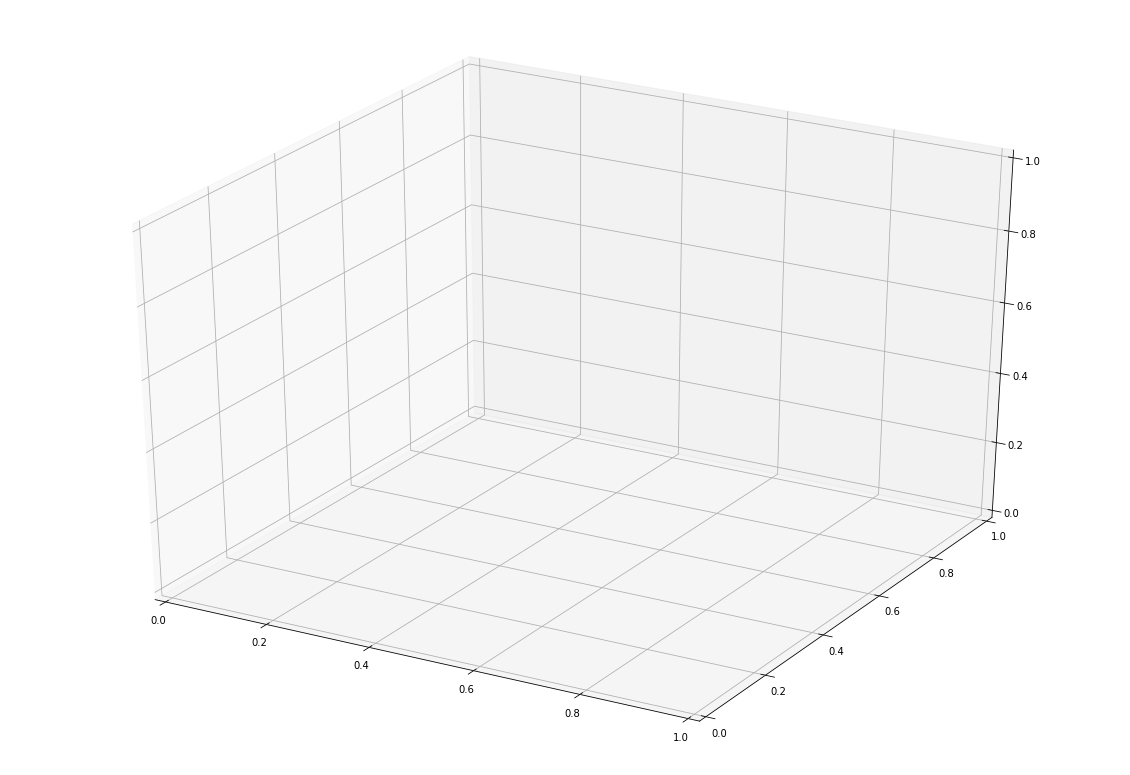

In [15]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (20, 14))
ax = plt.axes(projection ="3d")
   
ax.grid(b = True, color ='white',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)

ax.scatter3D(max_good, n_good, k_good, s = 50, color = 'yellow')
ax.scatter3D(max_bad, n_bad, k_bad, s = 350, color = 'black')


plt.title("Logistic regression whole dataset")
ax.set_xlabel('max-axis', fontweight ='bold')
ax.set_ylabel('n-axis', fontweight ='bold')
ax.set_zlabel('k-axis', fontweight ='bold')
ax.legend(['good', 'very bad'])
 
# show plot
plt.show()